In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats
import early_warning_detection_functions
import matplotlib.pyplot as plt
import geopandas as gpd


# Read the data

In [2]:
df = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_otc_phc_imed.parquet')
    
df_aih = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_aih_imed2.parquet')


df_imed_key = pd.read_csv('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RELATORIO_DTB_BRASIL_MUNICIPIO.csv',sep = ';')

df_pop = pd.read_csv('/Users/julianeoliveira/Documents/Projects/AESOP/AESOP datalake/Population/table_2009_2023_etcc_eq_zero.csv')

#'/home/juliane.oliveira/workspace/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_otc_phc_imed.parquet')
#/home/juliane.oliveira/workspace/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_aih_imed.parquet')                       

# Format data

In [3]:
df_aih = df_aih[df_aih.year_week >= '2022-47']

df_pop = df_pop[['Cód.', 'Uf', '2022']]

df_imed_key = df_imed_key[['Nome_UF', 'UF',  'Região Geográfica Imediata',
       'Nome Região Geográfica Imediata', 
       'Município', 'Código Município Completo', 'Nome_Município']]

df_pop = df_pop.rename(columns = {'Cód.': 'co_ibge7'}) 

df_imed_key = df_imed_key.rename(columns = {'Código Município Completo': 'co_ibge7', 
                                            'Região Geográfica Imediata': 'co_imed'})

df_imed_key = df_imed_key.merge(df_pop, on='co_ibge7', how='left')

df_imed_pop = df_imed_key.groupby(['co_imed'])['2022'].sum().reset_index()

df_imed_pop = df_imed_pop.assign(pop_2022 = df_imed_pop['2022'].astype(int))
df_imed_pop = df_imed_pop[['co_imed', 'pop_2022']]

df_aih = df_aih.assign(n = df_aih.n.astype(int))

df = df.assign(atend_ivas = df.atend_ivas.astype(int),
              num_otc_ivas = df.num_otc_ivas.astype(int))

df_codes_imed = df_imed_key.groupby(['Nome_UF','UF', 'co_imed','Uf'])['2022'].sum().reset_index()

df_aih = df_aih.merge(df_codes_imed, on='co_imed', how='left')

In [4]:
# Dictionary mapping Brazilian states to their regions
state_to_region = {
    "AC": "North", "AM": "North", "AP": "North", "PA": "North", "RO": "North", "RR": "North", "TO": "North",
    "AL": "Northeast", "BA": "Northeast", "CE": "Northeast", "MA": "Northeast", "PB": "Northeast",
    "PE": "Northeast", "PI": "Northeast", "RN": "Northeast", "SE": "Northeast",
    "DF": "Center-West", "GO": "Center-West", "MT": "Center-West", "MS": "Center-West",
    "ES": "Southeast", "MG": "Southeast", "RJ": "Southeast", "SP": "Southeast",
    "PR": "South", "RS": "South", "SC": "South"
}



# Create a new column 'region' by mapping state codes to regions
df["region"] = df["sigla_uf"].map(state_to_region)

df_aih["region"] = df_aih["Uf"].map(state_to_region)

df_pop["region"] = df_pop["Uf"].map(state_to_region)

df_codes_imed["region"] = df_codes_imed["Uf"].map(state_to_region)

In [5]:
df_codes_imed = df_codes_imed.rename(columns = {'2022': 'pop'})

In [6]:
bins = [0, 1.177890e+05, 3.247680e+05, float('inf')]
labels = ['Small', 'Medium', 'Large']

df_codes_imed['pop_cat'] = pd.cut(df_codes_imed['pop'], bins=bins, labels=labels, right=True)

In [11]:
#df_codes_imed.to_csv('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/dado_sup_fig1.csv')


# Descriptive analysis of AIH, APS and OTC

In [6]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return round(m), round(m-h), round(m+h)

## Period cover by AIH, APS and OTC data 

In [7]:
print('Period covered by APS and OTC is from ', df.year_week.min(), ' to', df.year_week.max())

Period covered by APS and OTC is from  2022-47  to 2024-52


In [8]:
print('Period covered by AIH is from ', df_aih.year_week.min(), ' to', df_aih.year_week.max())

Period covered by AIH is from  2022-47  to 2024-52


## Total number of encounters, OTC and AIH in the country

In [9]:
df.atend_ivas.sum()

51070528

In [10]:
dta_counts = df.groupby(['year_week'])['atend_ivas'].sum().reset_index()

In [11]:
mean_confidence_interval(dta_counts.atend_ivas, confidence=0.95)

(464278, 437213, 491342)

In [12]:
df.num_otc_ivas.sum()

584528064

In [13]:
dta_counts = df.groupby(['year_week'])['num_otc_ivas'].sum().reset_index()

In [14]:
mean_confidence_interval(dta_counts.num_otc_ivas.astype(int), confidence=0.95)

(5313891, 5058530, 5569253)

In [15]:
df_aih.n.sum()

1803478

In [16]:
dta_counts = df_aih.groupby(['year_week'])['n'].sum().reset_index()

In [17]:
mean_confidence_interval(dta_counts.n, confidence=0.95)

(16395, 15566, 17224)

## Total encounters, OTC and AIH by region

In [18]:
df.groupby(['region'])[['atend_ivas', 'num_otc_ivas']].sum().reset_index()

,region,atend_ivas,num_otc_ivas
0,Center-West,4955709,53398956
1,North,4163646,56914591
2,Northeast,11077821,133259206
3,South,11798297,80919836
4,Southeast,19075055,260035475


In [19]:
dta_counts = df.groupby(['region','year_week'])['atend_ivas'].sum().reset_index()
mean_confidence_interval(dta_counts[dta_counts.region == 'Center-West'].atend_ivas.astype(int), confidence=0.95)

(45052, 42034, 48070)

In [20]:
mean_confidence_interval(dta_counts[dta_counts.region == 'North'].atend_ivas.astype(int), confidence=0.95)

(37851, 35840, 39863)

In [21]:
mean_confidence_interval(dta_counts[dta_counts.region == 'Northeast'].atend_ivas.astype(int), confidence=0.95)

(100707, 94064, 107351)

In [22]:
mean_confidence_interval(dta_counts[dta_counts.region == 'Southeast'].atend_ivas.astype(int), confidence=0.95)

(173410, 163233, 183587)

In [23]:
dta_counts = df.groupby(['region','year_week'])['num_otc_ivas'].sum().reset_index()
mean_confidence_interval(dta_counts[dta_counts.region == 'Center-West'].num_otc_ivas.astype(int), confidence=0.95)

(485445, 457999, 512891)

In [24]:
mean_confidence_interval(dta_counts[dta_counts.region == 'North'].num_otc_ivas.astype(int), confidence=0.95)

(517405, 493704, 541107)

In [25]:
mean_confidence_interval(dta_counts[dta_counts.region == 'Northeast'].num_otc_ivas.astype(int), confidence=0.95)

(1211447, 1148214, 1274681)

In [26]:
mean_confidence_interval(dta_counts[dta_counts.region == 'Southeast'].num_otc_ivas.astype(int), confidence=0.95)

(2363959, 2241863, 2486054)

In [27]:
df_aih.groupby(['region'])['n'].sum().reset_index()

,region,n
0,Center-West,152647
1,North,186337
2,Northeast,483983
3,South,314837
4,Southeast,665674


In [28]:
df_aih.groupby(['region'])['2022'].sum().reset_index()

,region,2022
0,Center-West,1786599567
1,North,1904028824
2,Northeast,5998412062
3,South,3287979770
4,Southeast,9329724566


In [29]:
dta_counts = df_aih.groupby(['region','year_week'])['n'].sum().reset_index()
mean_confidence_interval(dta_counts[dta_counts.region == 'Center-West'].n.astype(int), confidence=0.95)

(1388, 1310, 1465)

In [30]:
mean_confidence_interval(dta_counts[dta_counts.region == 'North'].n.astype(int), confidence=0.95)

(1694, 1591, 1797)

In [31]:
mean_confidence_interval(dta_counts[dta_counts.region == 'Northeast'].n.astype(int), confidence=0.95)

(4400, 4151, 4649)

In [32]:
mean_confidence_interval(dta_counts[dta_counts.region == 'Southeast'].n.astype(int), confidence=0.95)

(6052, 5775, 6328)

## Proportion of cases per 100.000 inhabitants

In [33]:
### Total population
df_pop['2022'].astype(int).sum()

203062512

In [34]:
round(df.atend_ivas.sum()*100000/df_pop['2022'].astype(int).sum(),1)

25150.2

In [35]:
round(df.num_otc_ivas.sum()*100000/df_pop['2022'].astype(int).sum(),1)

287856.2

In [36]:
round(df_aih.n.sum()*100000/df_pop['2022'].astype(int).sum(),1)

888.1

In [37]:
dta1 = df.groupby(['region'])[['atend_ivas', 'num_otc_ivas']].sum().reset_index()

In [38]:
dta2 = df_pop.groupby(['region'])['2022'].sum().reset_index()

In [39]:
dta3 = dta1.merge(dta2, on = 'region', how= 'left')

In [40]:
dta3 = dta3.assign(rate_aps = round(dta3.atend_ivas*100000/dta3['2022'],1),
                   rate_otc = round(dta3.num_otc_ivas*100000/dta3['2022'],1))                  

In [41]:
dta3

,region,atend_ivas,num_otc_ivas,2022,rate_aps,rate_otc
0,Center-West,4955709,53398956,16287809,30425.9,327846.2
1,North,4163646,56914591,17349619,23998.5,328045.2
2,Northeast,11077821,133259206,54644582,20272.5,243865.4
3,South,11798297,80919836,29933315,39415.3,270333.7
4,Southeast,19075055,260035475,84847187,22481.7,306475.1


In [42]:
# Example data: observed counts and population sizes for each region
counts = np.array(dta3.atend_ivas)
populations = np.array(dta3['2022'])  # Reverse calculation

# Expected counts under equal rate assumption
expected = populations * (sum(counts) / sum(populations))

# Chi-square test
chi2, p_value = stats.chisquare(counts, f_exp=expected)

print(f"Chi-square statistic: {chi2:.2f}, p-value: {p_value:.6f}")

# Interpretation
if p_value < 0.05:
    print("Significant difference in rates across regions.")
else:
    print("No significant difference in rates across regions.")


Chi-square statistic: 3368510.68, p-value: 0.000000
Significant difference in rates across regions.


In [43]:
# Example data: observed counts and population sizes for each region
counts = np.array(dta3.num_otc_ivas)
populations = np.array(dta3['2022'])  # Reverse calculation

# Expected counts under equal rate assumption
expected = populations * (sum(counts) / sum(populations))

# Chi-square test
chi2, p_value = stats.chisquare(counts, f_exp=expected)

print(f"Chi-square statistic: {chi2:.2f}, p-value: {p_value:.6f}")

# Interpretation
if p_value < 0.05:
    print("Significant difference in rates across regions.")
else:
    print("No significant difference in rates across regions.")


Chi-square statistic: 6893080.30, p-value: 0.000000
Significant difference in rates across regions.


In [44]:
dta4 = df_aih.groupby(['region'])[['n','2022']].sum().reset_index()

In [45]:
dta4 = dta4.assign(rate_aih = round(dta4.n*100000/dta4['2022'],1))

In [46]:
dta4

,region,n,2022,rate_aih
0,Center-West,152647,1786599567,8.5
1,North,186337,1904028824,9.8
2,Northeast,483983,5998412062,8.1
3,South,314837,3287979770,9.6
4,Southeast,665674,9329724566,7.1


In [47]:
# Example data: observed counts and population sizes for each region
counts = np.array(dta4.n)
populations = np.array(dta4['2022'])  # Reverse calculation

# Expected counts under equal rate assumption
expected = populations * (sum(counts) / sum(populations))

# Chi-square test
chi2, p_value = stats.chisquare(counts, f_exp=expected)

print(f"Chi-square statistic: {chi2:.2f}, p-value: {p_value:.6f}")

# Interpretation
if p_value < 0.05:
    print("Significant difference in rates across regions.")
else:
    print("No significant difference in rates across regions.")


Chi-square statistic: 26733.84, p-value: 0.000000
Significant difference in rates across regions.


## Spatial visualization

In [50]:
df_imed_map = df.groupby(['co_imed', 'Nome_imed'])[['atend_ivas','num_otc_ivas']].sum().reset_index()

In [51]:
df_aih_group = df_aih.groupby(['co_imed'])[['n']].sum().reset_index()

In [52]:
df_aih_group = df_aih_group.assign(co_imed = df_aih_group.co_imed.astype(str))
df_imed_map = df_imed_map.assign(co_imed = df_imed_map.co_imed.astype(str))

df_imed_pop = df_imed_pop.assign(co_imed = df_imed_pop.co_imed.astype(str))

In [53]:
df_imed_map = df_imed_map.merge(df_aih_group, on='co_imed', how='left')

In [54]:
df_imed_map = df_imed_map.merge(df_imed_pop, on='co_imed', how='left')

In [55]:
# Load shapefile of immediate regions (you need to download this from IBGE)
shapefile_path = '/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RG2017_rgi_20180911/RG2017_rgi.shp'  # update with actual file
gdf = gpd.read_file(shapefile_path)

# Make sure 'co_imed' in both files is string for easier merge
gdf['co_imed'] = gdf['rgi']  # Adjust if the column is different in your file
gdf['co_imed'] = gdf['co_imed'].astype(str)
data = df_imed_map
data['co_imed'] = data['co_imed'].astype(str)

# Merge the shapefile with your data
gdf = gdf.merge(data, on='co_imed', how='left')


In [56]:
gdf = gdf.assign(aps_inc = gdf.atend_ivas.astype(int)*100000/gdf['pop_2022'],
                 otc_inc = gdf.num_otc_ivas.astype(int)*100000/gdf['pop_2022'],
                 aih_inc = gdf.n.astype(int)*100000/gdf['pop_2022'])

In [57]:
gdf.aih_inc.describe()

count     510.000000
mean     1171.282736
std       498.334495
min       349.429425
25%       811.090560
50%      1087.533269
75%      1451.268277
max      3190.630611
Name: aih_inc, dtype: float64

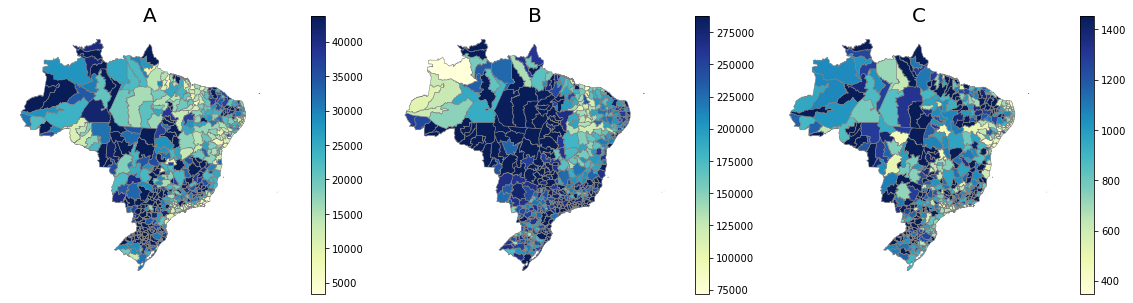

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Plot the first map - APS incidence with clipped color scale
gdf.plot(column='aps_inc',
         cmap='YlGnBu',
         linewidth=0.5,
         ax=ax[0],
         edgecolor='gray',
         legend=True,
         vmax=43704.755618,
         legend_kwds={'shrink': 0.5}  # Shrinks the colorbar (0.5 = half the default size)
         )
         
        
ax[0].set_title('A', fontsize=20)
ax[0].axis('off')

# Plot the second map - OTC incidence with clipped color scale
gdf.plot(column='otc_inc',
         cmap='YlGnBu',
         linewidth=0.5,
         ax=ax[1],
         edgecolor='gray',
         legend=True,
         vmax=2.872972e+05,
         legend_kwds={'shrink': 0.5}  # Shrinks the colorbar (0.5 = half the default size)
         )

ax[1].set_title('B', fontsize=20)
ax[1].axis('off')

# Plot the second map - AIH incidence with clipped color scale
gdf.plot(column='aih_inc',
         cmap='YlGnBu',
         linewidth=0.5,
         ax=ax[2],
         edgecolor='gray',
         legend=True,
         vmax = 1451.687889,
         legend_kwds={'shrink': 0.5}  # Shrinks the colorbar (0.5 = half the default size)
         )

ax[2].set_title('C', fontsize=20)
ax[2].axis('off')

# Adjust spacing
plt.tight_layout()

plt.savefig('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/map_aih_otc_aps.png', dpi=300, bbox_inches='tight')
plt.savefig('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/map_aih_otc_aps.pdf', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [60]:
gdf.to_csv('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_fig2.csv')

In [61]:
res = stats.spearmanr(gdf.n.to_numpy(), gdf.atend_ivas.to_numpy())
round(res.correlation,3), res.pvalue

(0.696, 5.568684825947748e-75)

In [62]:
res = stats.spearmanr(gdf.n.to_numpy(), gdf.num_otc_ivas.to_numpy())
round(res.correlation,3), res.pvalue

(0.803, 2.741677546192869e-116)

In [63]:
res = stats.spearmanr(gdf.atend_ivas.to_numpy(), gdf.num_otc_ivas.to_numpy())
round(res.correlation,3), res.pvalue

(0.642, 1.0583411929123646e-60)

In [64]:
df_codes_imed = df_codes_imed.assign(co_imed  = df_codes_imed.co_imed.astype(str))
gdf = gdf.merge(df_codes_imed, on = 'co_imed', how = 'left')

Correlation Coefficient (ρ)	Strength of Association

0.00 - 0.19	Very Weak

0.20 - 0.39	Weak

0.40 - 0.59	Moderate

0.60 - 0.79	Strong

0.80 - 1.00	Very Strong


In [65]:
# Function to classify correlation strength
def classify_correlation(value):
    if abs(value) < 0.2:
        return "Very Weak"
    elif abs(value) < 0.4:
        return "Weak"
    elif abs(value) < 0.6:
        return "Moderate"
    elif abs(value) < 0.8:
        return "Strong"
    else:
        return "Very Strong"

# Initialize an empty list to store results
results = []

# Loop through each region and calculate Spearman correlations
for value in gdf.region.unique():
    res_aih_phc = stats.spearmanr(gdf[gdf.region == value].n.to_numpy(), 
                                  gdf[gdf.region == value].atend_ivas.to_numpy())
    
    res_aih_otc = stats.spearmanr(gdf[gdf.region == value].n.to_numpy(), 
                                  gdf[gdf.region == value].num_otc_ivas.to_numpy())
    
    res_phc_otc = stats.spearmanr(gdf[gdf.region == value].atend_ivas.to_numpy(), 
                                  gdf[gdf.region == value].num_otc_ivas.to_numpy())

    # Append results to the list with correlation classification
    results.append([value, 'AIH and PHC', res_aih_phc.correlation, res_aih_phc.pvalue, classify_correlation(res_aih_phc.correlation)])
    results.append([value, 'AIH and OTC', res_aih_otc.correlation, res_aih_otc.pvalue, classify_correlation(res_aih_otc.correlation)])
    results.append([value, 'PHC and OTC', res_phc_otc.correlation, res_phc_otc.pvalue, classify_correlation(res_phc_otc.correlation)])

# Create DataFrame from results list
df_results = pd.DataFrame(results, columns=['Region', 'Comparison', 'Spearman Correlation', 'P-Value', 'Strength'])

# Display the table
print(df_results)

         Region   Comparison  Spearman Correlation       P-Value     Strength
0         North  AIH and PHC              0.594974  3.401565e-07     Moderate
1         North  AIH and OTC              0.851981  1.646922e-18  Very Strong
2         North  PHC and OTC              0.697716  2.942245e-10       Strong
3     Northeast  AIH and PHC              0.726749  1.427330e-26       Strong
4     Northeast  AIH and OTC              0.742104  3.380837e-28       Strong
5     Northeast  PHC and OTC              0.794232  1.047695e-34       Strong
6     Southeast  AIH and PHC              0.637856  6.241439e-18       Strong
7     Southeast  AIH and OTC              0.799793  1.671288e-33       Strong
8     Southeast  PHC and OTC              0.462781  4.611971e-09     Moderate
9         South  AIH and PHC              0.836997  2.376155e-26  Very Strong
10        South  AIH and OTC              0.873778  3.487248e-31  Very Strong
11        South  PHC and OTC              0.747680  2.110648e-18

## Trend and seazonality 

In [74]:
df_otc = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_otc_only_imed.parquet')

    
#'/home/juliane.oliveira/workspace/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_otc_only_imed.parquet')

In [75]:

# Classification columns for PHC and OTC
df['phc_trend'] = df['p_values_negbi_atend_ivas_4'] < 0.05
df['phc_seasonality'] = df['p_value_ivas_negbi_friedman'] < 0.05

df['otc_trend'] = df['p_values_negbi_num_otc_ivas_4'] < 0.05
df['otc_seasonality'] = df['p_value_otc_negbi_friedman'] < 0.05

# Convert to string labels for easier understanding
df['phc_trend_label'] = df['phc_trend'].map({True: 'Trend', False: 'No Trend'})
df['phc_seasonality_label'] = df['phc_seasonality'].map({True: 'Seasonality', False: 'No Seasonality'})

df['otc_trend_label'] = df['otc_trend'].map({True: 'Trend', False: 'No Trend'})
df['otc_seasonality_label'] = df['otc_seasonality'].map({True: 'Seasonality', False: 'No Seasonality'})

# Group by co_imed (or whatever your region column is) and classify each region
classification = (df
    .groupby('co_imed')
    .agg(
        phc_trend=('phc_trend_label', 'first'),
        phc_seasonality=('phc_seasonality_label', 'first'),
        otc_trend=('otc_trend_label', 'first'),
        otc_seasonality=('otc_seasonality_label', 'first')
    )
    .reset_index()
)

# Count combinations across all regions
combination_counts = (classification
    .groupby(['phc_trend', 'phc_seasonality', 'otc_trend', 'otc_seasonality'])
    .size()
    .reset_index(name='count')
)


In [76]:
combination_counts = combination_counts.assign(count_per = round(combination_counts['count']*100/510,1))

In [77]:
combination_counts

,phc_trend,phc_seasonality,otc_trend,otc_seasonality,count,count_per
0,No Trend,No Seasonality,No Trend,No Seasonality,33,6.5
1,No Trend,No Seasonality,No Trend,Seasonality,46,9.0
2,No Trend,No Seasonality,Trend,No Seasonality,16,3.1
3,No Trend,No Seasonality,Trend,Seasonality,7,1.4
4,No Trend,Seasonality,No Trend,No Seasonality,144,28.2
5,No Trend,Seasonality,No Trend,Seasonality,163,32.0
6,No Trend,Seasonality,Trend,No Seasonality,41,8.0
7,No Trend,Seasonality,Trend,Seasonality,22,4.3
8,Trend,No Seasonality,No Trend,No Seasonality,3,0.6
9,Trend,No Seasonality,No Trend,Seasonality,4,0.8


## Plot of different patterns in APS timeseries

In [78]:
df_sez_aps = df[df.phc_seasonality == True]

In [79]:
lst_dfs_cities = []

for code in df_sez_aps.co_imed.unique():
    
    set_muni = df_sez_aps[df_sez_aps.co_imed == code]

    lst_dfs_cities.append(set_muni)

lst_dfs_cities = early_warning_detection_functions.harmonic(lst_dfs_cities, 'atend_ivas_4')

/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


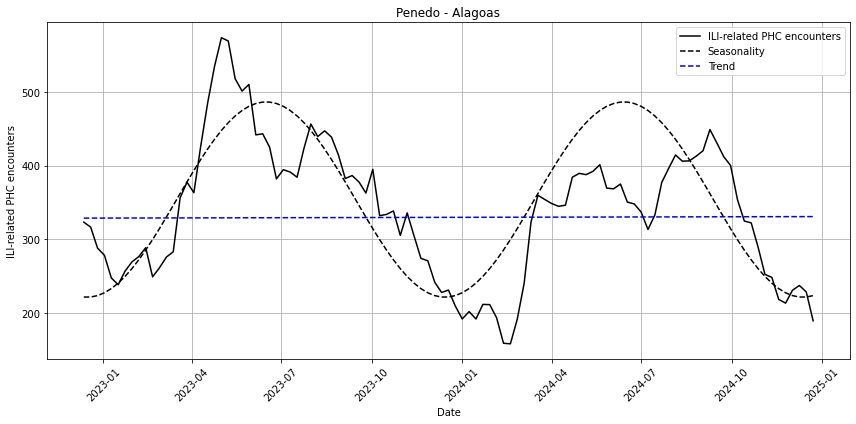

In [80]:
# 4
s = 4
# Ensure 'year_week' is in datetime format (convert 'year_week' to datetime)
dates= pd.to_datetime(lst_dfs_cities[s]['year_week_ts'])

trend = lst_dfs_cities[s].atend_ivas_4 - lst_dfs_cities[s].dtrend_ivas_negbi  

# Plotting the components
plt.figure(figsize=(12, 6))

# Plot original series
plt.plot(dates[3:], lst_dfs_cities[s]['atend_ivas_4'][3:], label='ILI-related PHC encounters', color='black')

# Plot seasonality
plt.plot(dates[3:], lst_dfs_cities[s]['Reconstructed'][3:], label='Seasonality', color='black', linestyle='dashed')

# Plot trend
plt.plot(dates[3:], trend[3:], label='Trend', color='blue', linestyle='dashed')

# Formatting the plot
plt.title(lst_dfs_cities[4].Nome_imed.iloc[0] + ' - ' + lst_dfs_cities[4].nm_uf.iloc[0])
plt.xlabel('Date')
plt.ylabel('ILI-related PHC encounters')
plt.xticks(rotation=45)  # Rotate date labels for better visibility

# Set grid for better readability
plt.grid(True)

# Add legend to the plot
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [81]:
dta1 = lst_dfs_cities[s][['year_week_ts', 'atend_ivas_4', 'Reconstructed']]

dta1 = dta1.assign(trend = trend)

In [82]:
df_sez_trend_aps = df[(df.phc_seasonality == True) & (df.phc_trend == True)]

In [83]:
lst_dfs_cities1 = []

for code in df_sez_trend_aps.co_imed.unique():
    
    set_muni = df_sez_trend_aps[df_sez_trend_aps.co_imed == code]

    lst_dfs_cities1.append(set_muni)

lst_dfs_cities1 = early_warning_detection_functions.harmonic(lst_dfs_cities1, 'atend_ivas_4')

/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


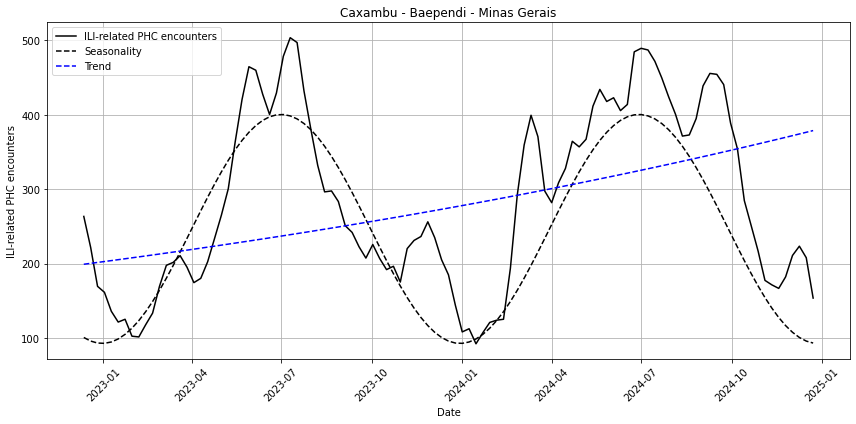

In [84]:
# 2, 6
s = 7
# Ensure 'year_week' is in datetime format (convert 'year_week' to datetime)
dates= pd.to_datetime(lst_dfs_cities1[s]['year_week_ts'])

trend = lst_dfs_cities1[s].atend_ivas_4 - lst_dfs_cities1[s].dtrend_ivas_negbi  

# Plotting the components
plt.figure(figsize=(12, 6))

# Plot original series
plt.plot(dates[3:], lst_dfs_cities1[s]['atend_ivas_4'][3:], label='ILI-related PHC encounters', color='black')

# Plot seasonality
plt.plot(dates[3:], lst_dfs_cities1[s]['Reconstructed'][3:], label='Seasonality', color='black', linestyle='dashed')

# Plot trend
plt.plot(dates[3:], trend[3:], label='Trend', color='blue', linestyle='dashed')

# Formatting the plot
plt.title(lst_dfs_cities1[s].Nome_imed.iloc[0] + ' - ' + lst_dfs_cities1[s].nm_uf.iloc[0])
plt.xlabel('Date')
plt.ylabel('ILI-related PHC encounters')
plt.xticks(rotation=45)  # Rotate date labels for better visibility

# Set grid for better readability
plt.grid(True)

# Add legend to the plot
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [85]:
dta2 = lst_dfs_cities1[s][['year_week_ts', 'atend_ivas_4', 'Reconstructed']]

dta2 = dta2.assign(trend = lst_dfs_cities1[s].atend_ivas_4 - lst_dfs_cities1[s].dtrend_ivas_negbi  )

In [86]:
df_trend_aps = df[(df.phc_seasonality == False) & (df.phc_trend == True)]

In [87]:
lst = []
for code in df_trend_aps.co_imed.unique():
    set_data = df_trend_aps[df_trend_aps.co_imed == code]

    lst.append(set_data)

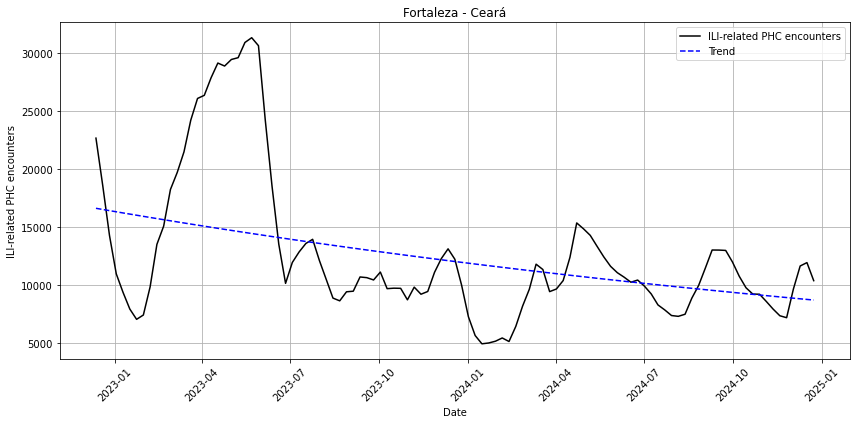

In [88]:
s = 0#0
# Ensure 'year_week' is in datetime format (convert 'year_week' to datetime)

dates= pd.to_datetime(lst[s]['year_week_ts'])

trend = lst[s].atend_ivas_4 - lst[s].dtrend_ivas_negbi  

# Plotting the components
plt.figure(figsize=(12, 6))

# Plot original series
plt.plot(dates[3:], lst[s]['atend_ivas_4'][3:], label='ILI-related PHC encounters', color='black')

# Plot seasonality
#plt.plot(dates[3:], lst_dfs_cities1[s]['Reconstructed'][3:], label='Seasonality', color='black', linestyle='dashed')

# Plot trend
plt.plot(dates[3:], trend[3:], label='Trend', color='blue', linestyle='dashed')

# Formatting the plot
plt.title(lst[s].Nome_imed.iloc[0] + ' - ' + lst[s].nm_uf.iloc[0])
plt.xlabel('Date')
plt.ylabel('ILI-related PHC encounters')
plt.xticks(rotation=45)  # Rotate date labels for better visibility

# Set grid for better readability
plt.grid(True)

# Add legend to the plot
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [89]:
dta3 = lst[s][['year_week_ts', 'atend_ivas_4']]

dta3 = dta3.assign(trend = lst[s].atend_ivas_4 - lst[s].dtrend_ivas_negbi)

In [90]:
df_no = df[(df.phc_seasonality == False) & (df.phc_trend == False)]

In [91]:
lst1 = []
for code in df_no.co_imed.unique():
    set_data = df_no[df_no.co_imed == code]

    lst1.append(set_data)

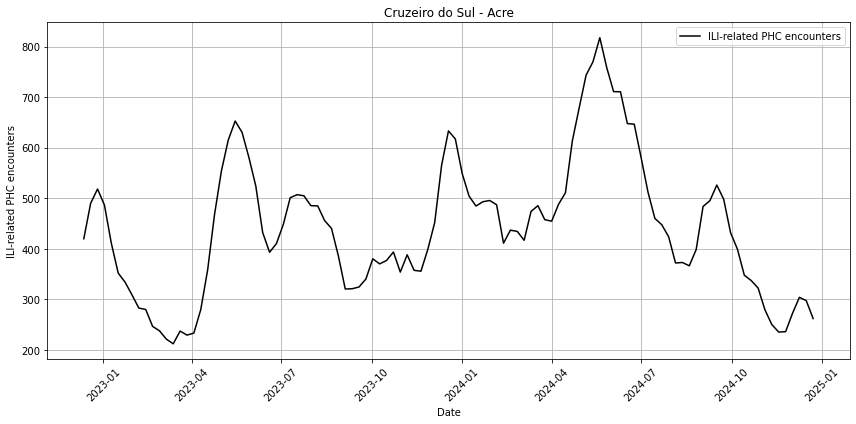

In [92]:
s = 1#0
# Ensure 'year_week' is in datetime format (convert 'year_week' to datetime)

dates= pd.to_datetime(lst1[s]['year_week_ts'])

trend = lst1[s].atend_ivas_4 - lst1[s].dtrend_ivas_negbi  

# Plotting the components
plt.figure(figsize=(12, 6))

# Plot original series
plt.plot(dates[3:], lst1[s]['atend_ivas_4'][3:], label='ILI-related PHC encounters', color='black')

# Plot seasonality
#plt.plot(dates[3:], lst_dfs_cities1[s]['Reconstructed'][3:], label='Seasonality', color='black', linestyle='dashed')

# Plot trend
#plt.plot(dates[3:], trend[3:], label='Trend', color='blue', linestyle='dashed')

# Formatting the plot
plt.title(lst1[s].Nome_imed.iloc[0] + ' - ' + lst1[s].nm_uf.iloc[0])
plt.xlabel('Date')
plt.ylabel('ILI-related PHC encounters')
plt.xticks(rotation=45)  # Rotate date labels for better visibility

# Set grid for better readability
plt.grid(True)

# Add legend to the plot
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [93]:
dta4 = lst1[s][['year_week_ts', 'atend_ivas_4']]

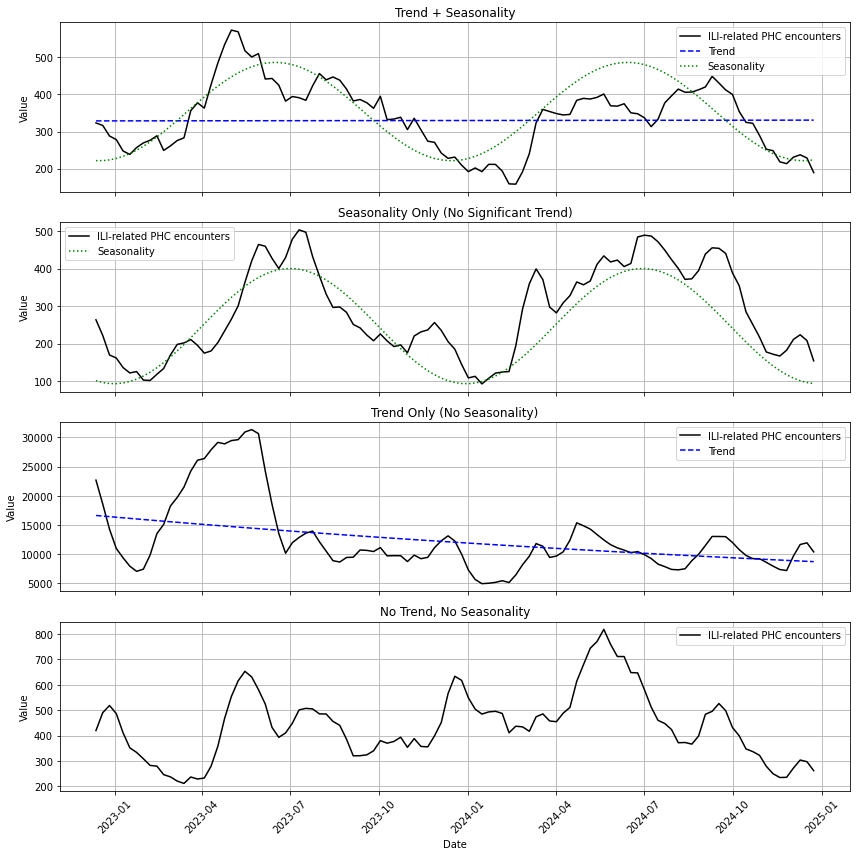

In [94]:
# Example dates for all panels
dates = pd.to_datetime(dta1['year_week_ts'])

# Set up panel plot with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Panel 1: Trend + Seasonality
axes[0].plot(dates[3:], dta1['atend_ivas_4'][3:], label='ILI-related PHC encounters', color='black')
axes[0].plot(dates[3:], dta1.trend[3:], label='Trend', color='blue', linestyle='dashed')
axes[0].plot(dates[3:], dta1.Reconstructed[3:], label='Seasonality', color='green', linestyle='dotted')
axes[0].set_title('Trend + Seasonality')
axes[0].legend()

# Panel 2: Seasonality only
axes[1].plot(dates[3:], dta2['atend_ivas_4'][3:], label='ILI-related PHC encounters', color='black')
axes[1].plot(dates[3:], dta2.Reconstructed[3:], label='Seasonality', color='green', linestyle='dotted')
axes[1].set_title('Seasonality Only (No Significant Trend)')
axes[1].legend()

# Panel 3: Trend only
axes[2].plot(dates[3:], dta3['atend_ivas_4'][3:], label='ILI-related PHC encounters', color='black')
axes[2].plot(dates[3:], dta3.trend[3:], label='Trend', color='blue', linestyle='dashed')
axes[2].set_title('Trend Only (No Seasonality)')
axes[2].legend()

# Panel 4: No Trend, No Seasonality (just noise)
axes[3].plot(dates[3:], dta4['atend_ivas_4'][3:], label='ILI-related PHC encounters', color='black')
axes[3].set_title('No Trend, No Seasonality')
axes[3].legend()

# Formatting
for ax in axes:
    ax.grid(True)
    ax.set_ylabel('Value')
    ax.legend()

# Common x-axis label
plt.xlabel('Date')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Analyse pic of seazonalities

In [95]:
df_sez_aps = df[df.phc_seasonality == True]

lst_dfs_cities = []

for code in df_sez_aps.co_imed.unique():
    
    set_muni = df_sez_aps[df_sez_aps.co_imed == code]

    lst_dfs_cities.append(set_muni)

lst_dfs_cities = early_warning_detection_functions.harmonic(lst_dfs_cities, 'atend_ivas_4')

/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [96]:
lst = []
for data in lst_dfs_cities:
    data = data[['sigla_uf', 'co_uf', 'nm_uf', 'co_imed', 'Nome_imed', 'year_week',
       'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end', 'atend_ivas',
       'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',  'Reconstructed',
                 ]]
    
    new_data = data[data.Reconstructed == data.Reconstructed.max()]
    
    lst.append(new_data)

In [97]:
res_sez_pic = pd.concat(lst)

In [98]:
res_sez_pic = res_sez_pic.assign(year_week_ts =  pd.to_datetime(res_sez_pic['year_week_ts']))

In [99]:
res_sez_pic = res_sez_pic.assign(year_month = res_sez_pic.year_week_ts.dt.to_period('M')) 

In [100]:
res_sez_pic = res_sez_pic.assign(month = res_sez_pic['year_month'].astype(str).str[-2:].astype(int))


In [101]:
pic_dates = res_sez_pic.groupby(['co_imed'])['month'].max().reset_index()

In [265]:
pic_dates.month.value_counts()

6     217
5     113
7      36
4      26
3       3
12      2
9       1
1       1
Name: month, dtype: int64

In [266]:
pic_dates

,co_imed,month
0,120001,7
1,120002,6
2,120005,7
3,130001,5
4,130002,5
...,...,...
394,520018,4
395,520019,5
396,520020,5
397,520021,6


In [267]:
round(399*100/510,1)

78.2

In [244]:
# Load shapefile of immediate regions (you need to download this from IBGE)
shapefile_path = '/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RG2017_rgi_20180911/RG2017_rgi.shp'  # update with actual file
gdf = gpd.read_file(shapefile_path)

# Make sure 'co_imed' in both files is string for easier merge
gdf['co_imed'] = gdf['rgi']  # Adjust if the column is different in your file
gdf['co_imed'] = gdf['co_imed'].astype(str)
data = pic_dates
data['co_imed'] = data['co_imed'].astype(str)

# Merge the shapefile with your data
gdf = gdf.merge(data, on='co_imed', how='left')


In [234]:
#gdf['month'] = gdf['month'].fillna('No Peak')

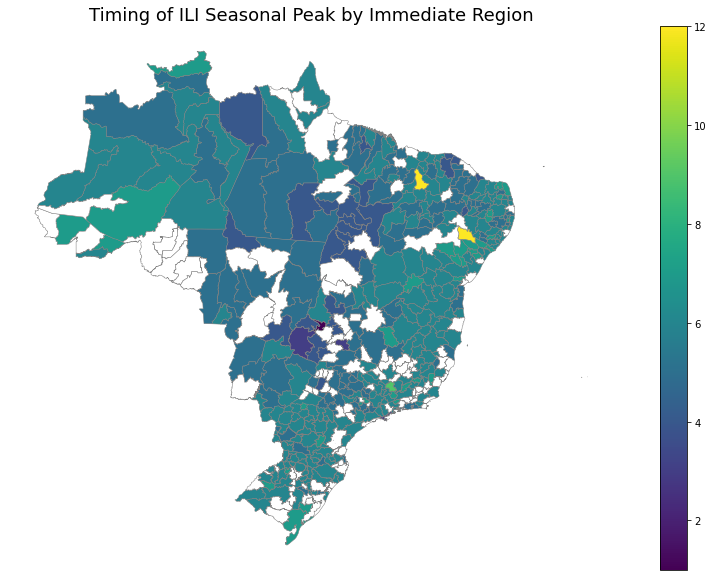

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

gdf.plot(column='month',
         cmap='viridis',
         linewidth=0.5,
         ax=ax,
         edgecolor='gray',
         legend=True,
         missing_kwds={
             "color": "white",         # Use white for areas with missing data (no peak)
             "label": "No Peak"         # Legend label for these areas
         })

ax.set_title('Timing of ILI Seasonal Peak by Immediate Region', fontsize=18)
ax.axis('off')

plt.show()


## Plot of different patterns in OTC timeseries

In [169]:
df_sez_otc = df[df.otc_seasonality == True]

In [170]:
lst_dfs_cities = []

for code in df_sez_otc.co_imed.unique():
    
    set_muni = df_sez_otc[df_sez_otc.co_imed == code]

    lst_dfs_cities.append(set_muni)

lst_dfs_cities = early_warning_detection_functions.harmonic(lst_dfs_cities, 'num_otc_ivas_4')

/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


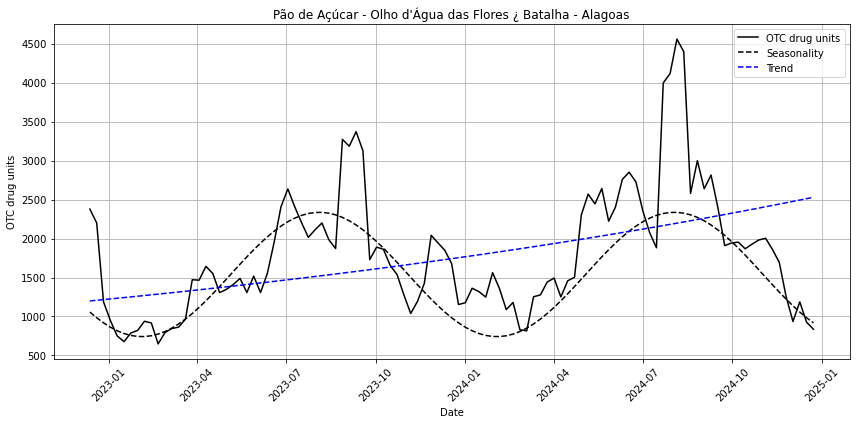

In [171]:
# 4
s = 2
# Ensure 'year_week' is in datetime format (convert 'year_week' to datetime)
dates= pd.to_datetime(lst_dfs_cities[s]['year_week_ts'])

trend = lst_dfs_cities[s].num_otc_ivas_4 - lst_dfs_cities[s].dtrend_otc_negbi  

# Plotting the components
plt.figure(figsize=(12, 6))

# Plot original series
plt.plot(dates[3:], lst_dfs_cities[s]['num_otc_ivas_4'][3:], label='OTC drug units', color='black')

# Plot seasonality
plt.plot(dates[3:], lst_dfs_cities[s]['Reconstructed'][3:], label='Seasonality', color='black', linestyle='dashed')

# Plot trend
plt.plot(dates[3:], trend[3:], label='Trend', color='blue', linestyle='dashed')

# Formatting the plot
plt.title(lst_dfs_cities[s].Nome_imed.iloc[0] + ' - ' + lst_dfs_cities[s].nm_uf.iloc[0])
plt.xlabel('Date')
plt.ylabel('OTC drug units')
plt.xticks(rotation=45)  # Rotate date labels for better visibility

# Set grid for better readability
plt.grid(True)

# Add legend to the plot
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [172]:
dta1 = lst_dfs_cities[s][['year_week_ts', 'num_otc_ivas_4', 'Reconstructed']]

dta1 = dta1.assign(trend = trend)

In [173]:
df_sez_trend_otc = df[(df.otc_seasonality == True) & (df.otc_trend == False)]

In [174]:
lst_dfs_cities1 = []

for code in df_sez_trend_otc.co_imed.unique():
    
    set_muni = df_sez_trend_otc[df_sez_trend_otc.co_imed == code]

    lst_dfs_cities1.append(set_muni)

lst_dfs_cities1 = early_warning_detection_functions.harmonic(lst_dfs_cities1, 'num_otc_ivas_4')

/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


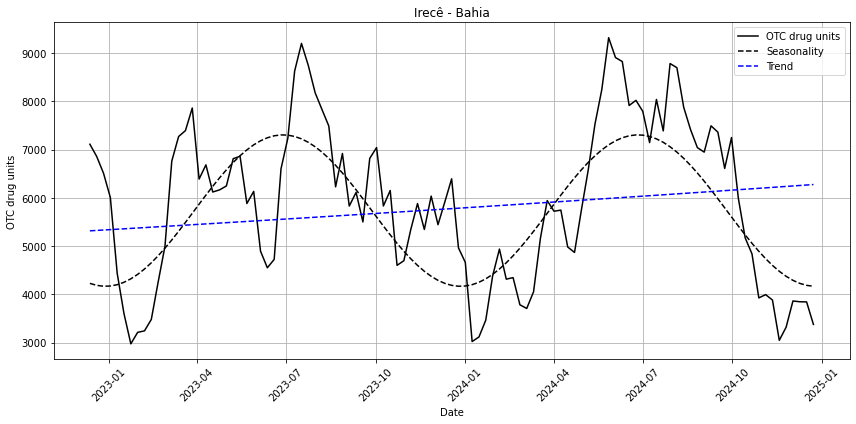

In [176]:
# 2, 6
s = 7
# Ensure 'year_week' is in datetime format (convert 'year_week' to datetime)
dates= pd.to_datetime(lst_dfs_cities1[s]['year_week_ts'])

trend = lst_dfs_cities1[s].num_otc_ivas_4 - lst_dfs_cities1[s].dtrend_otc_negbi  

# Plotting the components
plt.figure(figsize=(12, 6))

# Plot original series
plt.plot(dates[3:], lst_dfs_cities1[s]['num_otc_ivas_4'][3:], label='OTC drug units', color='black')

# Plot seasonality
plt.plot(dates[3:], lst_dfs_cities1[s]['Reconstructed'][3:], label='Seasonality', color='black', linestyle='dashed')

# Plot trend
plt.plot(dates[3:], trend[3:], label='Trend', color='blue', linestyle='dashed')

# Formatting the plot
plt.title(lst_dfs_cities1[s].Nome_imed.iloc[0] + ' - ' + lst_dfs_cities1[s].nm_uf.iloc[0])
plt.xlabel('Date')
plt.ylabel('OTC drug units')
plt.xticks(rotation=45)  # Rotate date labels for better visibility

# Set grid for better readability
plt.grid(True)

# Add legend to the plot
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [177]:
dta2 = lst_dfs_cities1[s][['year_week_ts', 'num_otc_ivas_4', 'Reconstructed']]

dta2 = dta2.assign(trend = lst_dfs_cities1[s].num_otc_ivas_4 - lst_dfs_cities1[s].dtrend_otc_negbi  )

In [178]:
df_trend_otc = df[(df.otc_seasonality == False) & (df.otc_trend == True)]

In [179]:
lst = []
for code in df_trend_otc.co_imed.unique():
    set_data = df_trend_otc[df_trend_otc.co_imed == code]

    lst.append(set_data)

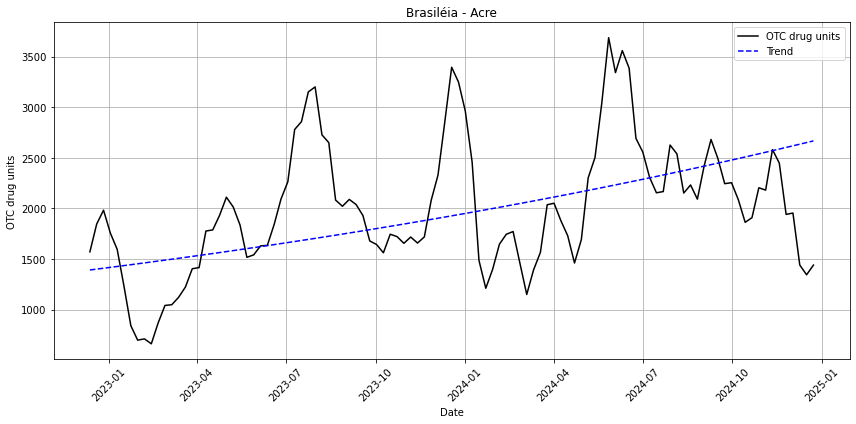

In [180]:
s = 0#0
# Ensure 'year_week' is in datetime format (convert 'year_week' to datetime)

dates= pd.to_datetime(lst[s]['year_week_ts'])

trend = lst[s].num_otc_ivas_4 - lst[s].dtrend_otc_negbi  

# Plotting the components
plt.figure(figsize=(12, 6))

# Plot original series
plt.plot(dates[3:], lst[s]['num_otc_ivas_4'][3:], label='OTC drug units', color='black')

# Plot seasonality
#plt.plot(dates[3:], lst_dfs_cities1[s]['Reconstructed'][3:], label='Seasonality', color='black', linestyle='dashed')

# Plot trend
plt.plot(dates[3:], trend[3:], label='Trend', color='blue', linestyle='dashed')

# Formatting the plot
plt.title(lst[s].Nome_imed.iloc[0] + ' - ' + lst[s].nm_uf.iloc[0])
plt.xlabel('Date')
plt.ylabel('OTC drug units')
plt.xticks(rotation=45)  # Rotate date labels for better visibility

# Set grid for better readability
plt.grid(True)

# Add legend to the plot
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [181]:
dta3 = lst[s][['year_week_ts', 'num_otc_ivas_4']]

dta3 = dta3.assign(trend = lst[s].num_otc_ivas_4 - lst[s].dtrend_otc_negbi)

In [182]:
df_no = df[(df.otc_seasonality == False) & (df.otc_trend == False)]

In [183]:
lst1 = []
for code in df_no.co_imed.unique():
    set_data = df_no[df_no.co_imed == code]

    lst1.append(set_data)

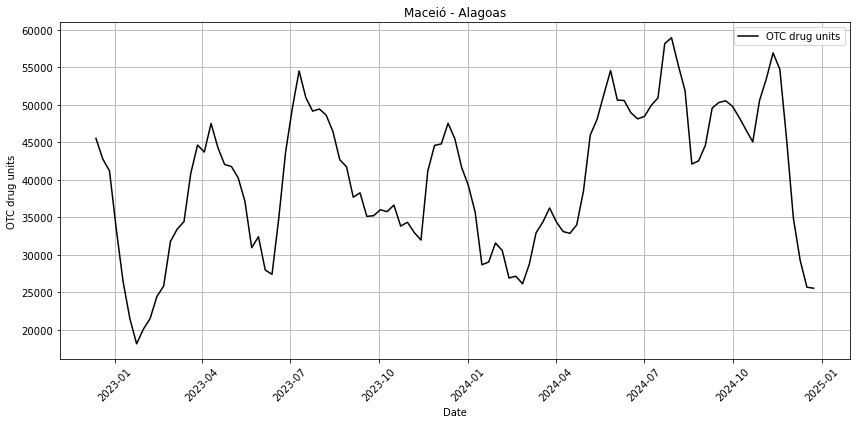

In [184]:
s = 1#0
# Ensure 'year_week' is in datetime format (convert 'year_week' to datetime)

dates= pd.to_datetime(lst1[s]['year_week_ts'])

trend = lst1[s].num_otc_ivas_4 - lst1[s].dtrend_otc_negbi  

# Plotting the components
plt.figure(figsize=(12, 6))

# Plot original series
plt.plot(dates[3:], lst1[s]['num_otc_ivas_4'][3:], label='OTC drug units', color='black')

# Plot seasonality
#plt.plot(dates[3:], lst_dfs_cities1[s]['Reconstructed'][3:], label='Seasonality', color='black', linestyle='dashed')

# Plot trend
#plt.plot(dates[3:], trend[3:], label='Trend', color='blue', linestyle='dashed')

# Formatting the plot
plt.title(lst1[s].Nome_imed.iloc[0] + ' - ' + lst1[s].nm_uf.iloc[0])
plt.xlabel('Date')
plt.ylabel('OTC drug units')
plt.xticks(rotation=45)  # Rotate date labels for better visibility

# Set grid for better readability
plt.grid(True)

# Add legend to the plot
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [186]:
dta4 = lst1[s][['year_week_ts', 'num_otc_ivas_4']]

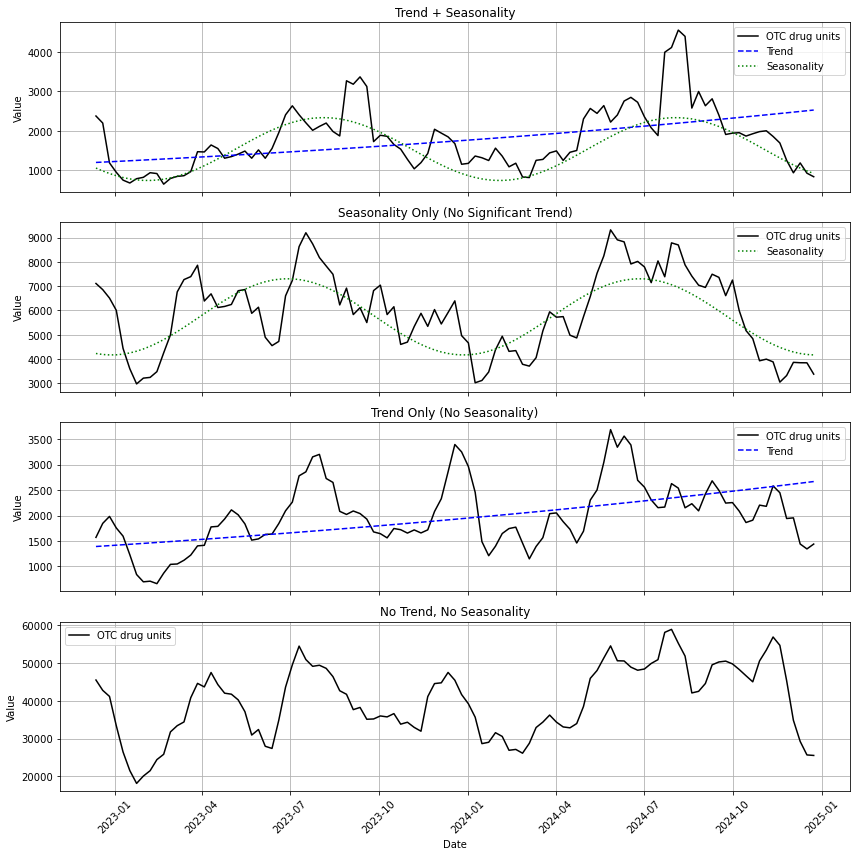

In [187]:
# Example dates for all panels
dates = pd.to_datetime(dta1['year_week_ts'])

# Set up panel plot with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Panel 1: Trend + Seasonality
axes[0].plot(dates[3:], dta1['num_otc_ivas_4'][3:], label='OTC drug units', color='black')
axes[0].plot(dates[3:], dta1.trend[3:], label='Trend', color='blue', linestyle='dashed')
axes[0].plot(dates[3:], dta1.Reconstructed[3:], label='Seasonality', color='green', linestyle='dotted')
axes[0].set_title('Trend + Seasonality')
axes[0].legend()

# Panel 2: Seasonality only
axes[1].plot(dates[3:], dta2['num_otc_ivas_4'][3:], label='OTC drug units', color='black')
axes[1].plot(dates[3:], dta2.Reconstructed[3:], label='Seasonality', color='green', linestyle='dotted')
axes[1].set_title('Seasonality Only (No Significant Trend)')
axes[1].legend()

# Panel 3: Trend only
axes[2].plot(dates[3:], dta3['num_otc_ivas_4'][3:], label='OTC drug units', color='black')
axes[2].plot(dates[3:], dta3.trend[3:], label='Trend', color='blue', linestyle='dashed')
axes[2].set_title('Trend Only (No Seasonality)')
axes[2].legend()

# Panel 4: No Trend, No Seasonality (just noise)
axes[3].plot(dates[3:], dta4['num_otc_ivas_4'][3:], label='OTC drug units', color='black')
axes[3].set_title('No Trend, No Seasonality')
axes[3].legend()

# Formatting
for ax in axes:
    ax.grid(True)
    ax.set_ylabel('Value')
    ax.legend()

# Common x-axis label
plt.xlabel('Date')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [246]:
df_sez_otc = df[df.otc_seasonality == True]

lst_dfs_cities = []

for code in df_sez_otc.co_imed.unique():
    
    set_muni = df_sez_otc[df_sez_otc.co_imed == code]

    lst_dfs_cities.append(set_muni)

lst_dfs_cities = early_warning_detection_functions.harmonic(lst_dfs_cities, 'num_otc_ivas_4')

/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [247]:
lst = []
for data in lst_dfs_cities:
    data = data[['sigla_uf', 'co_uf', 'nm_uf', 'co_imed', 'Nome_imed', 'year_week',
       'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end', 'atend_ivas',
       'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',  'Reconstructed',
                 ]]
    
    new_data = data[data.Reconstructed == data.Reconstructed.max()]
    
    lst.append(new_data)

In [248]:
res_sez_pic = pd.concat(lst)

In [249]:
res_sez_pic = res_sez_pic.assign(year_week_ts =  pd.to_datetime(res_sez_pic['year_week_ts']))

In [250]:
res_sez_pic = res_sez_pic.assign(year_month = res_sez_pic.year_week_ts.dt.to_period('M')) 

In [251]:
res_sez_pic = res_sez_pic.assign(month = res_sez_pic['year_month'].astype(str).str[-2:].astype(int))


In [252]:
pic_dates = res_sez_pic.groupby(['co_imed'])['month'].max().reset_index()

In [253]:
pic_dates.month.value_counts()

6     134
7     112
5       5
4       2
8       2
2       1
10      1
Name: month, dtype: int64

In [257]:
pic_dates

,co_imed,month
0,130008,7
1,210007,7
2,210013,6
3,210015,4
4,220002,6
...,...,...
252,520012,6
253,520015,7
254,520017,6
255,520019,6


In [268]:
round(257*100/510,1)

50.4

In [254]:
# Load shapefile of immediate regions (you need to download this from IBGE)
shapefile_path = '/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RG2017_rgi_20180911/RG2017_rgi.shp'  # update with actual file
gdf = gpd.read_file(shapefile_path)

# Make sure 'co_imed' in both files is string for easier merge
gdf['co_imed'] = gdf['rgi']  # Adjust if the column is different in your file
gdf['co_imed'] = gdf['co_imed'].astype(str)
data = pic_dates
data['co_imed'] = data['co_imed'].astype(str)

# Merge the shapefile with your data
gdf = gdf.merge(data, on='co_imed', how='left')


In [255]:
#gdf['month'] = gdf['month'].fillna('No Peak')

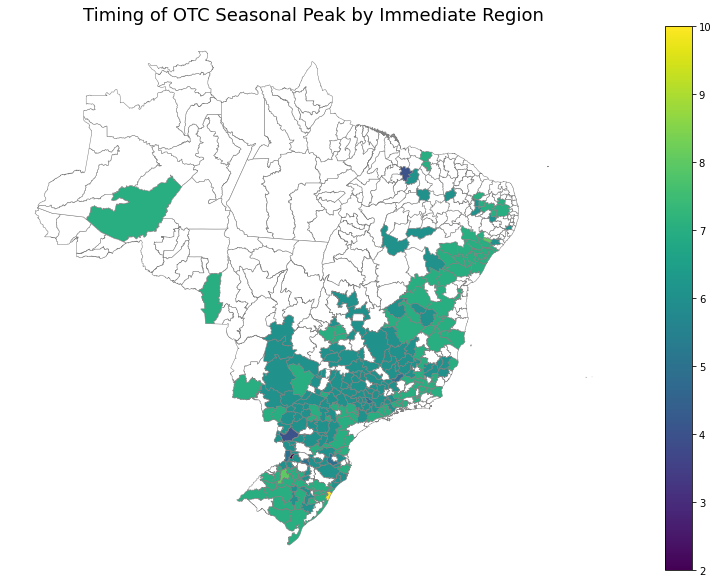

In [256]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

gdf.plot(column='month',
         cmap='viridis',
         linewidth=0.5,
         ax=ax,
         edgecolor='gray',
         legend=True,
         missing_kwds={
             "color": "white",         # Use white for areas with missing data (no peak)
             "label": "No Peak"         # Legend label for these areas
         })

ax.set_title('Timing of OTC Seasonal Peak by Immediate Region', fontsize=18)
ax.axis('off')

plt.show()


In [54]:
526*100/5570

9.443447037701976

In [56]:
246670*100/4973000

4.9601849989945705

In [57]:
718594*100/11472000

6.26389470013947

In [58]:
6.26389470013947  - 4.9601849989945705 

1.303709701144899

In [59]:
464116*100 / 11191000

4.147225449021535

In [60]:
246670*100/4973000 - 464116*100 / 11191000

0.8129595499730353